In [10]:
import sys
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from models import get_model
from datasets import MNISTSequencesDataset, NormaliseToZeroOneRange

from SNNCustomConfig import SNNCustomConfig

In [11]:
torch.manual_seed(0)
np.random.seed(0)

ingest_torch_dtype = torch.uint8
ingest_numpy_dtype = np.uint8

dtype = torch.float32

config = SNNCustomConfig(model_name="SNN1", dataset_name="mnist_sequences_250hz", configuration_name="config0_test")
print(config.params)

ConfigParser: Configuration file was not provided. Using default configuration for "SNN1_mnist_sequences_250hz".
{'dataset_sampling_frequency': 10, 'LIF_linear_features': 784, 'reset_mechanism': 'subtract', 'init_type': 'pure', 'grad_clipping': 'true', 'grad_clipping_max_norm': 1, 'membrane_time_constant_tao': 0.03, 'synaptic_time_constant_tao': 0.03, 'rheobase_multiplier': 0.13, 'rheobase_apply': 'true', 'input_multiplier': 1, 'torch_device': 'cuda', 'batch_size': 20, 'iterations': 1, 'epochs': 100, 'loss_type': 'L1Loss', 'loss_subtype': 'preactivation', 'optimiser_type': 'Adam', 'optimiser_learning_rate': 0.0005, 'optimiser_momentum': 0.9, 'optimiser_weight_decay': 0.006, 'dataloader_num_workers': 36, 'dataloader_pin_memory': True, 'scheduler_type': 'WarmupCosineLR', 'scheduler_StepLR_step_size': 5, 'scheduler_StepLR_gamma': 0.25, 'scheduler_WarmupCosineLR_warmup_factor': 0.001, 'scheduler_WarmupCosineLR_warmup_iterations': 3, 'scheduler_CosineAnnealingWarmRestarts_restart_period': 1

In [12]:
tao_mem = 0.03
timestep = 1/250
beta = np.exp(-timestep / tao_mem)

device = torch.device(config.params["torch_device"])

normalise_transform = NormaliseToZeroOneRange(dtype=dtype)
mnist_dataset = MNISTSequencesDataset(config.dirs["training"], config.params["LIF_linear_features"], ingest_numpy_dtype, ingest_torch_dtype, transform=normalise_transform)
train_loader = DataLoader(mnist_dataset, batch_size=config.params["batch_size"], shuffle=True, num_workers=config.params["dataloader_num_workers"])

In [13]:
config.data_shape = next(iter(train_loader)).shape

model_class = get_model(config.model_name)
model = model_class(num_steps=config.data_shape[1], beta=beta, alpha=1, LIF_linear_features=config.params["LIF_linear_features"], reset_mechanism=config.params["reset_mechanism"], dtype=dtype).to(device).to(dtype)

In [14]:
# config.params["init_type"] = 'pretrained'

In [15]:
# Initialisation of weights
if config.params["init_type"] == 'pretrained' and config.params["LIF_linear_features"] == 28*28:
    model.lif1.recurrent.weight.data = torch.Tensor(np.load(config.pretrained_weights_path)).to(device).to(dtype)
elif config.params["init_type"] == 'pretrained' and config.params["LIF_linear_features"] == 1024:
    class_weights_784 = torch.Tensor(np.load(config.pretrained_weights_path)).to(device).to(dtype)
    model.lif1.recurrent.weight.data[:class_weights_784.shape[0], :class_weights_784.shape[1]] = class_weights_784
    
weight_matrix = model.lif1.recurrent.weight.data.detach().cpu().numpy().copy()
bias_vector = model.lif1.recurrent.bias.data.detach().cpu().numpy().copy()

In [16]:
random_data = next(iter(train_loader)).to(device) * config.params['rheobase_multiplier'] * config.params['input_multiplier']
random_data.shape

torch.Size([20, 2625, 784])

In [17]:
model.eval()
spk_rec, mem_rec = model(random_data)

random_data = random_data.detach().cpu().numpy()
spk_rec = spk_rec.detach().cpu().numpy()
mem_rec = mem_rec.detach().cpu().numpy()

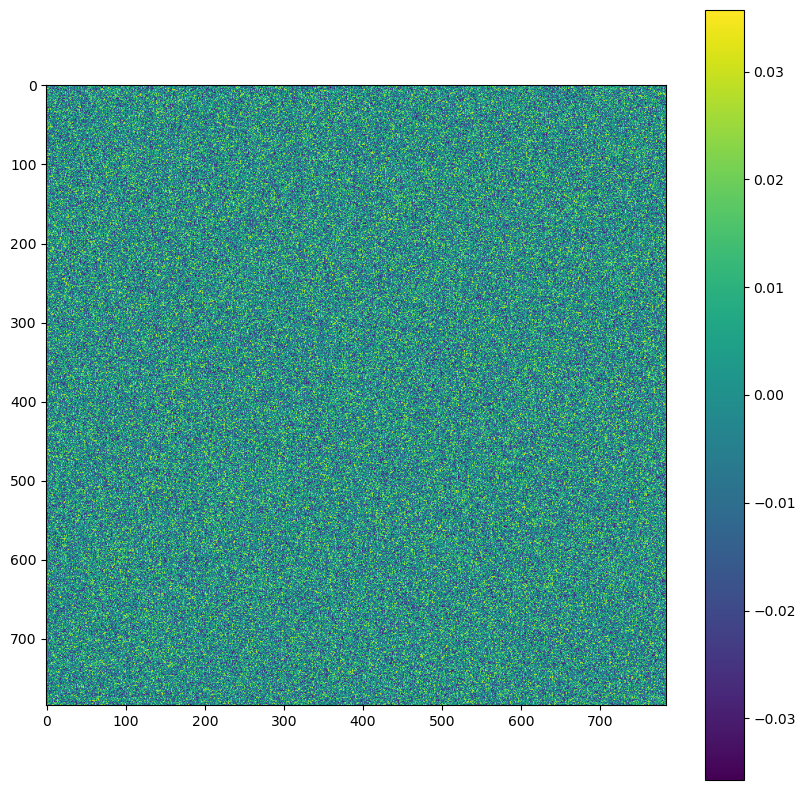

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(weight_matrix)
plt.colorbar()
plt.show()

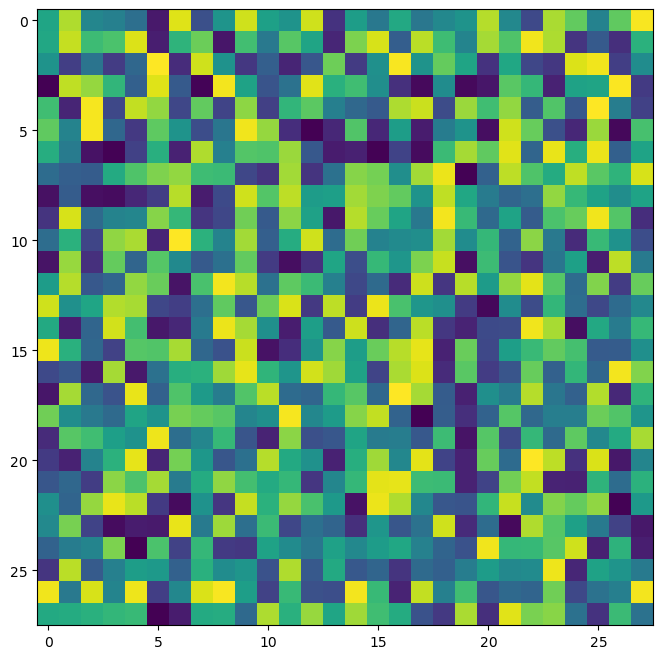

In [19]:
plt.figure(figsize=(14,8))
# plt.plot(weight_matrix[:,350])
plt.imshow(weight_matrix[:,350].reshape((28,28)))
plt.show()

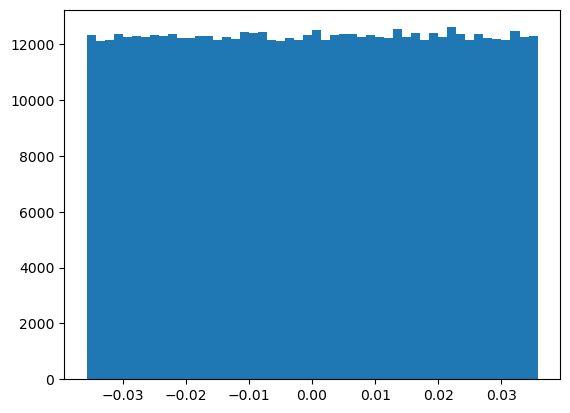

In [21]:
plt.hist(weight_matrix.flatten(), bins=50)
plt.show()

In [22]:
print("weight matrix")
print(weight_matrix.mean())
print(weight_matrix.std())
print(weight_matrix.max())
print(weight_matrix.min())
print('bias vector')
print(bias_vector.mean())
print(bias_vector.std())
print(bias_vector.max())
print(bias_vector.min())

weight matrix
2.6802245e-05
0.02061314
0.035714217
-0.035714276
bias vector
-0.0008230962
0.020711139
0.035608407
-0.03566178


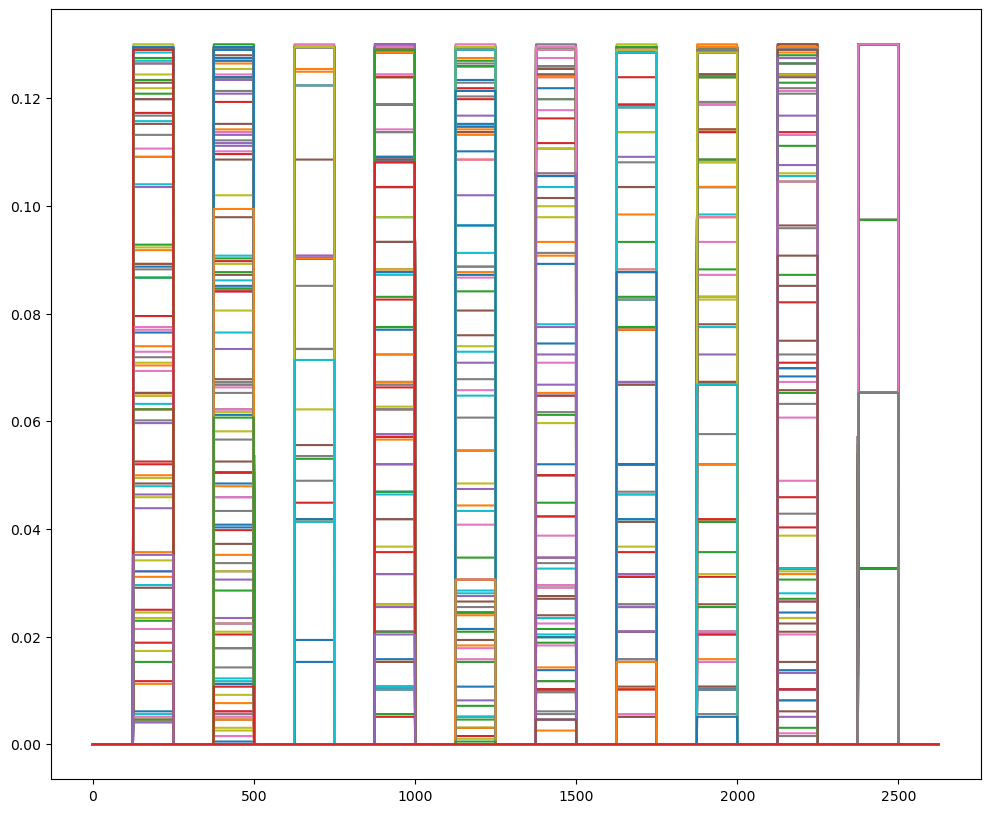

In [23]:
plt.figure(figsize=(12,10))
plt.plot(random_data[0,:,:])
# plt.xlim([100,400])
# plt.xlim([300,600])
plt.show()

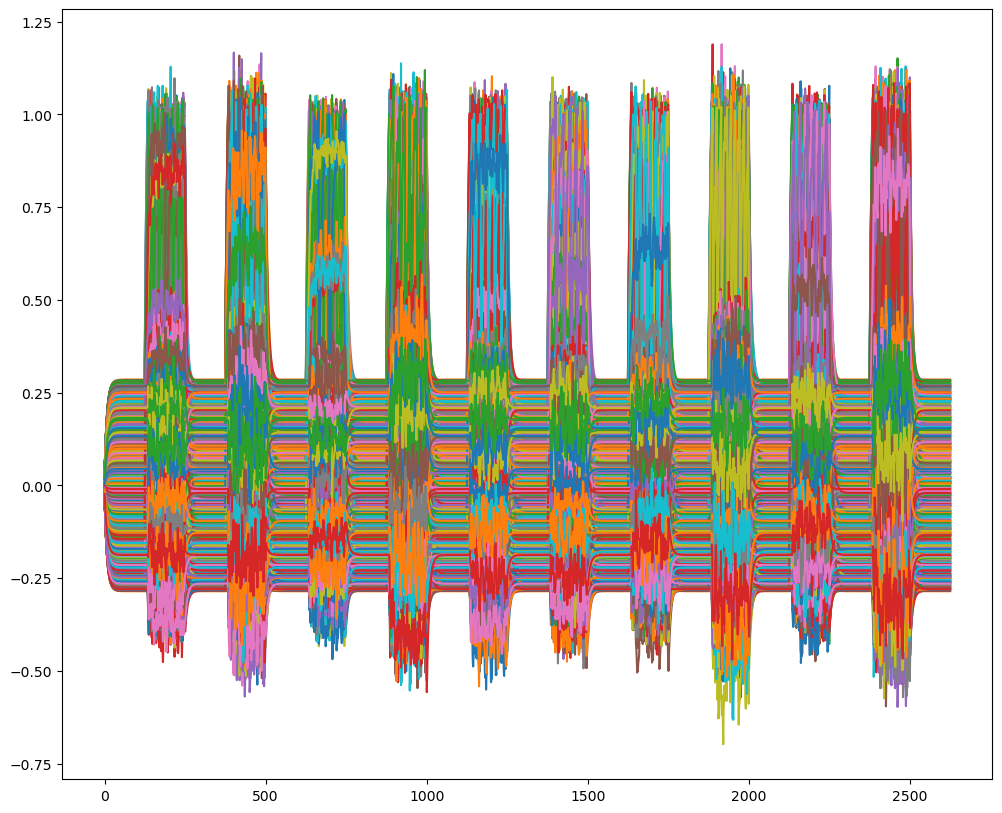

In [24]:
plt.figure(figsize=(12,10))
plt.plot(mem_rec[0,:,:])
# plt.xlim([100,400])
# plt.xlim([300,600])
# plt.xlim([600,800])
plt.show()

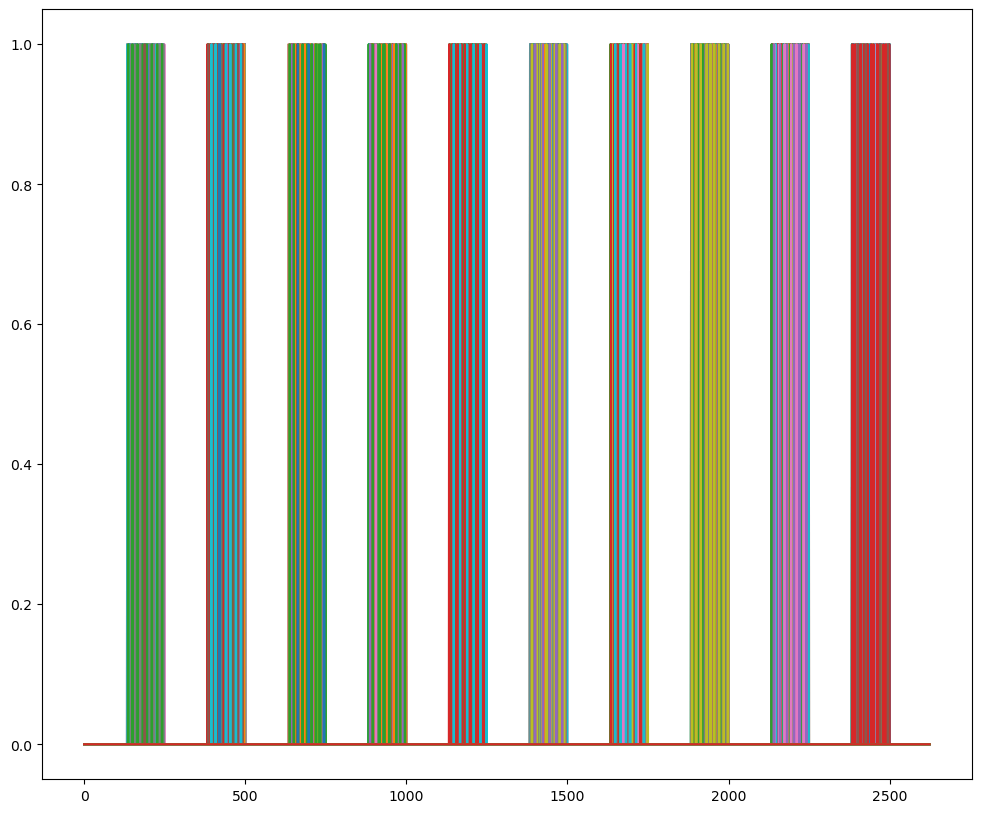

In [25]:
plt.figure(figsize=(12,10))
# plt.plot(spk_rec[0,:,500])
plt.plot(spk_rec[0,:,:])
# plt.xlim([600,800])
# plt.xlim([300,600])
plt.show()

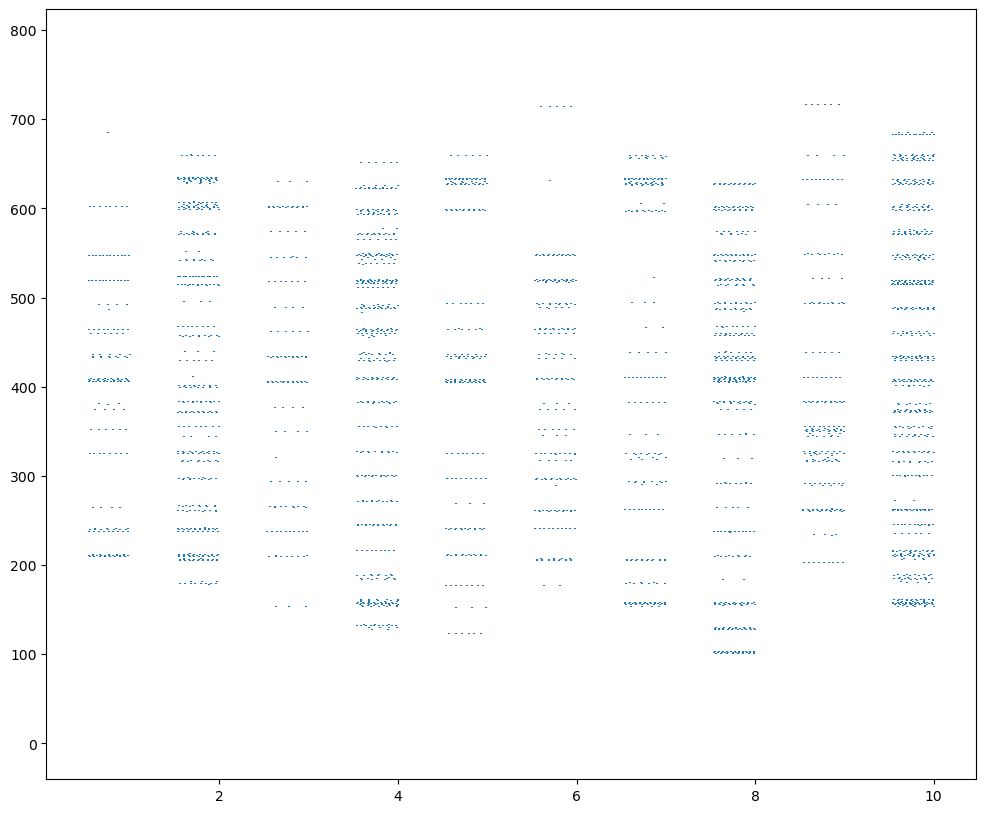

In [27]:
digit_duration = 0.5 # seconds
in_between_digit_period = 0.5 # seconds
number_of_digits = 10
sampling_freq = 250 # Hz

total_time = number_of_digits * digit_duration + (number_of_digits + 1) * in_between_digit_period
t = np.linspace(0, total_time, int(total_time*sampling_freq))
spkt_tims = [list(t[np.where(spk_rec[0,:,i]==1)]) for i in range(784)]

plt.figure(figsize=(12,10))
plt.eventplot(spkt_tims)
# plt.xlim([1.8, 1.82])
plt.show()

In [37]:
random_data[0][inds[0],inds[1]].shape

(1885500,)

In [42]:
inds = np.where(random_data[0].sum(axis=1) == 0)
# plt.plot(random_data[0][inds])
plt.scatter(np.arange(random_data[0][inds].shape, random_data[0][inds]))
# inds

ValueError: operands could not be broadcast together with shapes (1375,784) (2,) 

In [ ]:
arr1 = random_data[0,:,:].detach().cpu().numpy().reshape((random_data.shape[1], 28, 28))
arr2 = mem_rec[0,:,:].detach().cpu().numpy().reshape((random_data.shape[1], 28, 28))
arr3 = spk_rec[0,:,:].detach().cpu().numpy().reshape((random_data.shape[1], 28, 28))

from matplotlib.animation import FuncAnimation
plt.rcParams["animation.html"] = "jshtml"
# plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.dpi'] = 80
plt.ioff()

fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(8,6))

im1 = ax[0].imshow(np.zeros_like(arr1)[0], vmin=0, vmax=1)
im2 = ax[1].imshow(np.zeros_like(arr1)[0], vmin=arr2.min(), vmax=arr2.max())
im3 = ax[2].imshow(np.zeros_like(arr1)[0], vmin=0, vmax=1)


def init():
    im1.set_data(np.zeros_like(arr1[0,:,:]))
    im2.set_data(np.zeros_like(arr1[0,:,:]))
    im3.set_data(np.zeros_like(arr1[0,:,:]))
    return

def animate(t):
    im1.set_data(arr1[t,:,:]) 
    im2.set_data(arr2[t,:,:]) 
    im3.set_data(arr3[t,:,:]) 
    return

anim = FuncAnimation(fig, animate, init_func=init, frames=random_data.shape[1])
anim